In [58]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from sklearn import neighbors
import pandas as pd
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load, format, and normalize the data
Input data is stored in the file ParameterData.csv with a column to each parameter, a row to each trial, and both row and column headers. The classification indicator must be the last column and contain either the integer 0 or 1 only.

In [59]:
# Load data into data frame 
parameterDF = pd.read_csv("ParameterData.csv", header=0, index_col=0, sep=',')

In [60]:
# Normalize the data
params = parameterDF.columns.tolist() # List of labels for indexing and plotting
normDF = DataFrame()

for param in params[:-1]: # Normalize each parameter column (excluding the classification)
    normalizedData = ( parameterDF[param] - parameterDF[param].mean() ) / parameterDF[param].std()
    normDF = pd.concat( [normDF, Series(normalizedData) ], axis=1 )
    normDF.rename( columns={ 0:param } )

# Add the classification data back in
normDF = pd.concat( [normDF, parameterDF[ params[-1] ] ], axis=1 )

In [61]:
# Also group by classification
groups = normDF.groupby( normDF.columns[-1] )
successGroup = groups.get_group(1)
failureGroup = groups.get_group(0)

# Train KNN classifiers

In [62]:
numParams = len(params)-1 # For looping through parameters
k = (int)( sqrt(parameterDF.shape[1]) ) # k nearest neighbors
if k%2 is 0: # Want an odd k
    k += 1

In [63]:
classifiers = []
XTrains = []
XTests = []
yTrains = []
yTests = []
xMins = []
xMaxs = []
yMins = []
yMaxs = []

# Fit the classifiers
for rowNum in range(numParams):    
    for colNum in range(numParams):        
        if rowNum < colNum: # Exclude repeated plots       
            # Get data
            x1 = normDF[ params[colNum] ] # x-axis
            x2 = normDF[ params[rowNum] ] # y-axis
            X = np.column_stack( (x1, x2) )

            # Get overall min and max values for plotting and prediction testing
            xMin, xMax = x1.min(), x1.max() 
            yMin, yMax = x2.min(), x2.max()
            xMins.append(xMin), xMaxs.append(xMax), yMins.append(yMin), yMaxs.append(yMax)           
            
            # Split data into training and testing samples
            XTrain, XTest, yTrain, yTest = train_test_split(X, normDF[ params[-1] ])            
            XTrains.append(XTrain), XTests.append(XTest), yTrains.append(yTrain), yTests.append(yTest)
            
            # Fit the classifier
            classifier = neighbors.KNeighborsClassifier( k, weights='distance' ).fit(XTrain, yTrain)
            classifiers.append(classifier)

## Plot training data & prediction boundaries

In [64]:
h = 0.005  # Step size in the prediction mesh
colMap = ListedColormap( ['#F08080', '#98FB98'] ) # Prediction mesh colors
meshXs = []
meshYs = []
meshPredictions = []                
 
# Predict a meshgrid of data points
for num in range(len(classifiers)):    
    meshX, meshY = np.meshgrid(np.arange(xMins[num]-1, xMaxs[num]+1, h),
                               np.arange(yMins[num]-1, yMaxs[num]+1, h))
    meshXs.append(meshX), meshYs.append(meshY)
    meshPredicted = classifiers[num].predict(np.c_[meshX.ravel(), meshY.ravel()])
    meshPredicted = meshPredicted.reshape(meshX.shape)
    meshPredictions.append(meshPredicted)

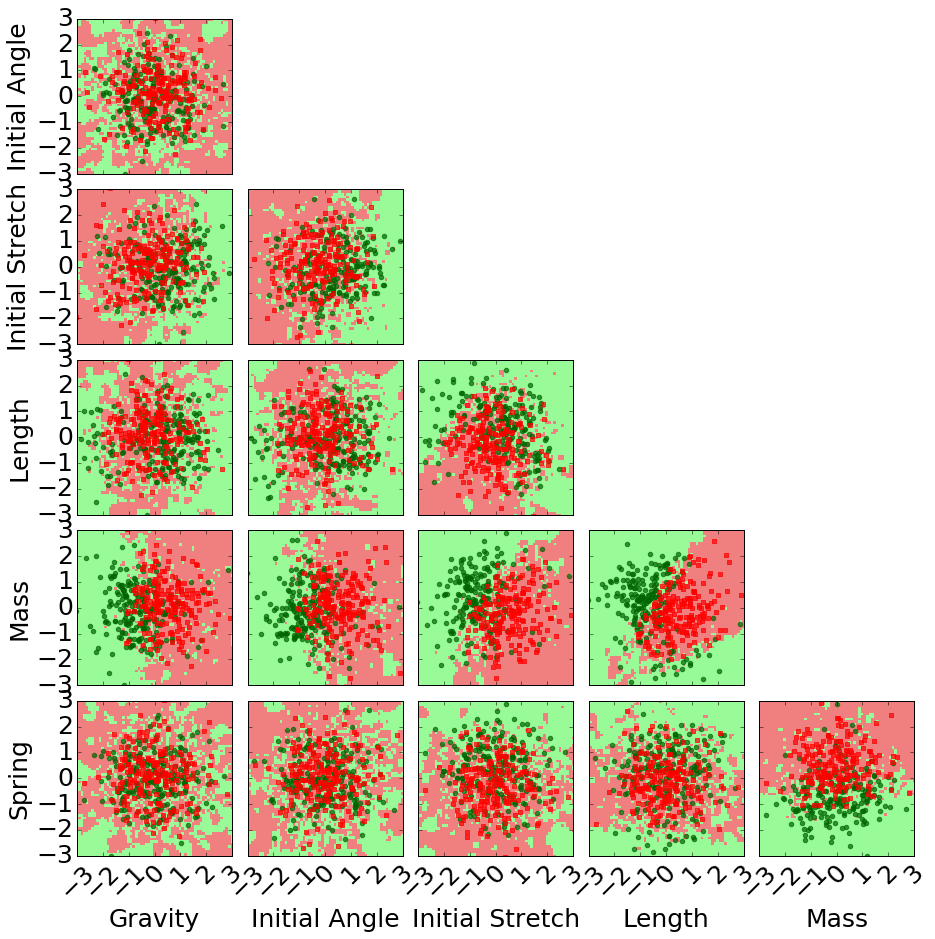

In [65]:
# Prepare the figure for plotting
plt.rcParams.update({'figure.autolayout': False})
plt.figure( figsize=(15,15) )
G = gridspec.GridSpec(numParams-1, numParams-1)
plt.subplots_adjust( hspace=0.1, wspace=0.1 ) 
plt.rc('font', size=25)
axarr = []
indices = [] # For indexing row and column labels

for xNum in range(numParams):
    for yNum in range(numParams):
        if xNum < yNum:
            indices.append( (params[xNum],params[yNum]) ) 
            ax = plt.subplot( G[yNum-1, xNum] )
            axarr.append(ax)
            if xNum is 0:
                plt.ylabel( params[yNum] )
            if xNum is not 0:
                plt.yticks( visible=False )
            if yNum is numParams-1:
                plt.xlabel( params[xNum] )
                plt.xticks( rotation=45 )
            if yNum is not numParams-1:
                plt.xticks( visible=False ) 

# Plot 
for num in range(len(indices)):                
    # Plot decision boundary
    axarr[num].pcolormesh(meshXs[num], meshYs[num], meshPredictions[num], cmap=colMap)
    
    # Plot the training data 
    xSuccesses = successGroup[ indices[num][1] ][:200] 
    ySuccesses = successGroup[ indices[num][0] ][:200]
    axarr[num].scatter( xSuccesses, ySuccesses, marker='o', color='#006400', alpha=0.7 )
    
    xFailures = failureGroup[ indices[num][1] ][:200]
    yFailures = failureGroup[ indices[num][0] ][:200]
    axarr[num].scatter( xFailures, yFailures, marker='s', color='#FF0000', alpha=0.7)
            
    axarr[num].set_xlim( -3,3 )
    axarr[num].set_ylim( -3,3 ) 
            
plt.savefig('KNNPlot_Distance.png')

# Test prediction accuracy

In [66]:
accuracyScores = []
comparisons = []

# Create list of labels
for xNum in range(numParams):
    for yNum in range(numParams):
        if xNum < yNum:
            comparisons.append( params[xNum]+' vs '+params[yNum] ) 

In [67]:
# Predict test data and find accuracy
for num in range(len(classifiers)):
    predicted = classifiers[num].predict( XTests[num] )
    acc = accuracy_score( yTests[num], predicted )
    accuracyScores.append(acc)

C:\Users\dsarg\Anaconda3\envs\py35qt4\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


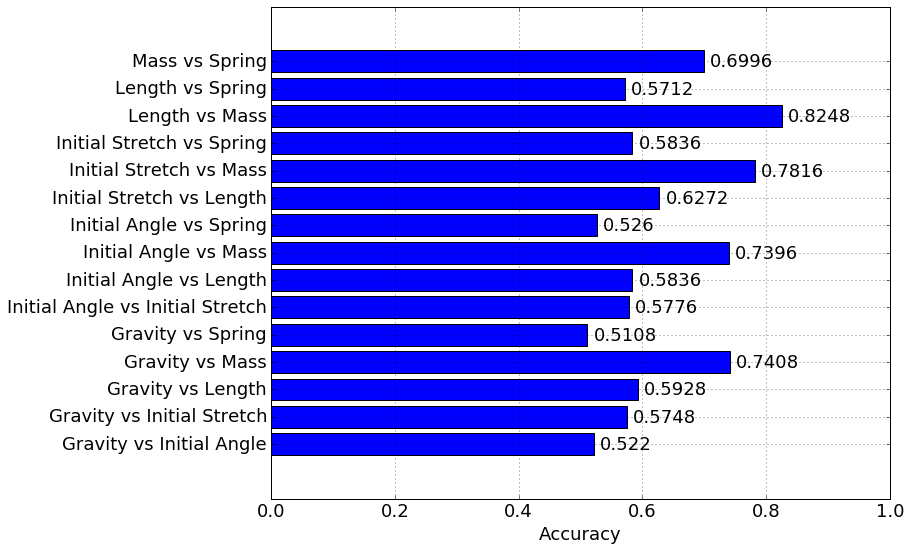

In [68]:
# Graph the accuracy (horizontal bar chart)
plt.rcParams.update({'figure.autolayout': True})
yAxis = np.arange(len(comparisons))
plt.rc('font', size=18)
plt.figure( figsize=(13,8) )
plt.barh(yAxis, accuracyScores, align='center')
for yPos, xPos in enumerate(accuracyScores):
    plt.gca().text(xPos+0.01, yPos-0.2, str(xPos))
plt.yticks(yAxis, comparisons)
plt.grid()
plt.xlim(0, 1.0)
plt.xlabel('Accuracy')
plt.savefig('KNN_DistAcc_HBars.png')